In [9]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
import pickle
import models 
import training 
import plot 
from utils import *
from dataset_loader import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
dataset_name = 'sentiment'
text_parser, label_parser, ds_train, ds_valid = get_dataset('sentiment')

Number of tokens in training samples: 6407
Number of tokens in training labels: 2


In [4]:
len(ds_train)

9000

In [5]:
len(ds_valid)

1433

## Forward Function For Getting Accuracy

In [6]:
import tqdm
def forward_dl(model, dl, device, type_dl):
    model.train(False)
    num_samples = len(dl) * dl.batch_size
    num_batches = len(dl)  
    pbar_name = type(model).__name__
    list_y_real = []
    list_y_pred = []
    pbar_file = sys.stdout
    num_correct = 0
    dl_iter = iter(dl)
    for batch_idx in range(num_batches):
        data = next(dl_iter)
        x, y = data.text, data.label
        list_y_real.append(y)
        x = x.to(device)  # (S, B, E)
        y = y.to(device)  # (B,)
        with torch.no_grad():
            if isinstance(model, models.VanillaGRU):
                y_pred_log_proba = model(x)
            elif isinstance(model, models.MultiHeadAttentionNet):
                y_pred_log_proba, _ = model(x)
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            list_y_pred.append(y_pred)
    accuracy = 100.0 * num_correct / num_samples
    print(f'Accuracy for {type_dl} is {accuracy}')
    
    all_y_real = torch.cat(list_y_real)
    all_y_pred = torch.cat(list_y_pred)
    return all_y_real, all_y_pred, accuracy

# Training Function

### Saves all the the output in the output directory

In [7]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device, output_directory = 'results'):
    NUM_EPOCHS = 100
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(text_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=text_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)
    dl_train, dl_valid = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid), batch_size=hp['batch_size'], sort = False, shuffle=True, device=device)

    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    loss_fn = nn.NLLLoss()
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)
    
    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))

    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    all_dataloaders = [dl_train, dl_valid]
    type_dls = ['train', 'valid', 'test']
    accuracies = []
    for dl, type_dl in zip(all_dataloaders, type_dls):
        y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
        df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
        accuracies.append(accuracy)
        display(df)
    numpy_accuracy = np.array(accuracies)
    df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
    df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

# Training GRU

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0001, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(6407, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Saving checkpoint with prefix: sentiment/gru
--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.693, Accuracy 50.122): 100%|█| 282/282 [00:01<00:00, 15
test_batch (Avg. Loss 0.692, Accuracy 52.083): 100%|█| 45/45 [00:00<00:00, 346.8
*** Saved checkpoint sentiment/gru.pt at epoch 1
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.694, Accuracy 49.391): 100%|█| 282/282 [00:01<00:00, 15
test_batch (Avg. Loss 0.696, Accuracy 47.847): 100%|█| 45/45 [00:00<00:00, 356.0
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.692, Accuracy 50.953): 100%|█| 282/282 [00:01<00:00, 16
test_batch (Avg. Loss 0.697, Accuracy

NameError: name 'compute_confusion_matrix' is not defined

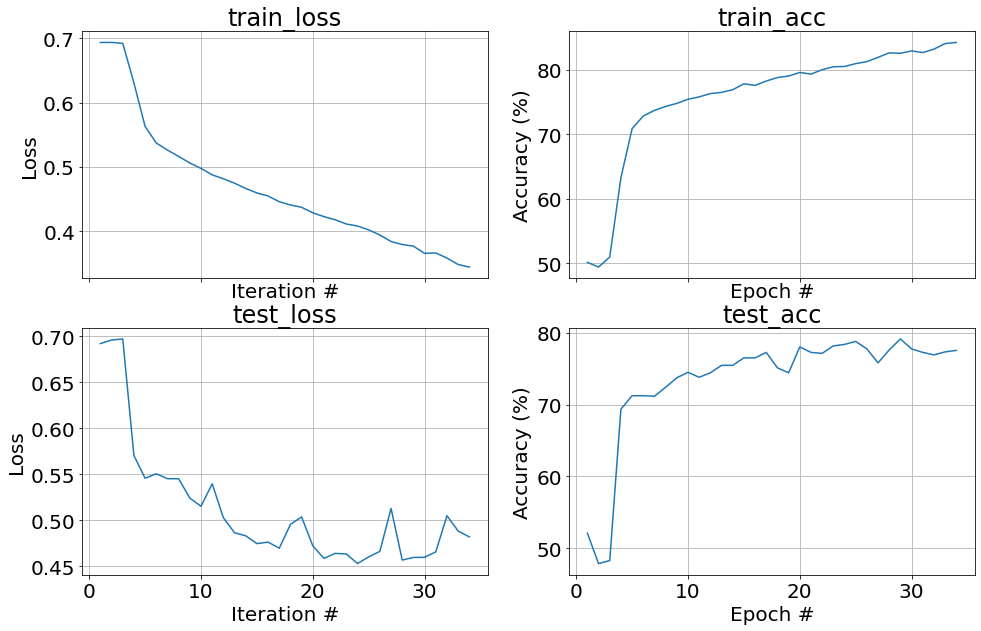

In [9]:
!rm sentiment/gru.pt
SEED = 84
torch.manual_seed(SEED)
train_model('gru', device, output_directory=dataset_name)

# Training Attention

In [4]:
SEED = 84
torch.manual_seed(SEED)
#train_model('attention', device, output_directory=dataset_name)

In [2]:
from nlputils import *
set_seed()

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd
from dataset_loader import twitter_preprocess
df = pd.read_csv('../dataset/corona_train.csv', encoding='latin-1')[['OriginalTweet', 'Sentiment']]
df = df[df['Sentiment']!='Neutral']
df['label'] = df['Sentiment'].map({'Positive': True, 'Extremely Positive': True,'Negative': False, 'Extremely Negative': False}) 
df['review'] = df['OriginalTweet'].apply(twitter_preprocess)
df = df[:10000][['review', 'label']]
dataset = Dataset.from_pandas(df)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [4]:
Dataset.from_pandas
ds = DatasetDict()

ds['train'] = Dataset.from_pandas(train).remove_columns(['__index_level_0__'])
ds['test'] = Dataset.from_pandas(test).remove_columns(['__index_level_0__'])

In [ ]:
ds['train']['label']

In [5]:
import nlputils
model = load_model('distilbert-base-uncased')
tokenized_data = tokenize_dataset(ds, tokenizer_name='distilbert-base-uncased', max_length = 64)
nlputils.train(model, tokenized_data)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

***** Running training *****
  Num examples = 8000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.339946,0.859000
2,0.303400,0.328005,0.882500


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.3034129943847656, metrics={'train_runtime': 37.6255, 'train_samples_per_second': 425.243, 'train_steps_per_second': 13.289, 'total_flos': 264934797312000.0, 'train_loss': 0.3034129943847656, 'epoch': 2.0})

In [6]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [14]:
def predict_sentences(sentences):
    encoded = [[101] +[tokenizer._convert_token_to_id_with_added_voc(token) for token in tokens] + [102]         
               for tokens in sentences]
    #encoded = tokenizer.encode(sentences, add_special_tokens=True, return_tensors="pt").to(device)
    to_pred = torch.tensor(encoded, device=device)
    outputs = model(to_pred)[0]
    print(outputs)
    return torch.argmax(outputs, dim=1).cpu().numpy()

In [6]:
model.save_pretrained('distilBert-corona/')

Configuration saved in distilBert-corona/config.json
Model weights saved in distilBert-corona/pytorch_model.bin


In [12]:
model = AutoModelForSequenceClassification.from_pretrained('distilBert-corona', num_labels=2, torchscript=True).to(device)
model = model.eval()

In [19]:
encoded = tokenizer.encode("i love movies", add_special_tokens=True, return_tensors="pt").to(device)
traced_model = torch.jit.trace(model, encoded)

In [ ]:
torch.jit.save(traced_model, "traced_bert-corona.pt")

In [20]:
predict_sentences([tokenizer.tokenize("i hate movies")])

tensor([[ 1.9930, -2.4401]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])